In [1]:
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
%%time

# set parquet data folder path
parquet_data_folder = '../data/crimes-2001-to-present.snappy.parq'
print('Loading crime data from: {}'.format(parquet_data_folder))

# load crimes parquet data into dask df
crimes = dd.read_parquet(parquet_data_folder, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading crime data from: ../data/crimes-2001-to-present.snappy.parq
Crime data loaded into memory.
Wall time: 14.7 s


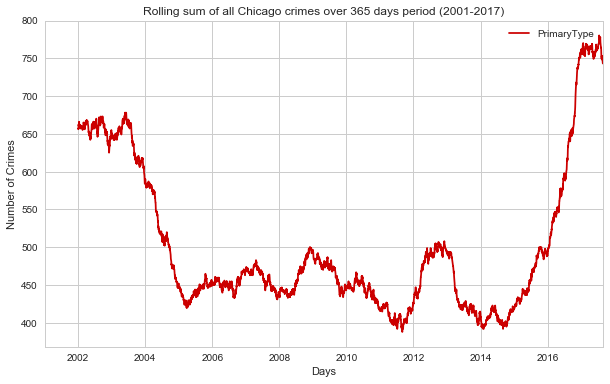

Wall time: 1.73 s


In [4]:
%%time

# get crime types
crime_types = crimes[['PrimaryType']]

# get homicides stats
homicides = crime_types[(crime_types['PrimaryType']=='HOMICIDE')]

# get crimes rolling sum for a smoother crime chart display
crimes_rolling_sum = homicides.resample('D').count().rolling(365).sum().compute()
crimes_rolling_sum.plot(figsize=(10,6), color='#cc0000')
plt.title('Rolling sum of Chicago Homicides over 365 days period (2001-2017)')
plt.xlabel('Days')
plt.ylabel('Number of Homicides')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()